In [1]:
import numpy as np
from tqdm.autonotebook import tqdm
import warnings, traceback
import easyocr

from IndexUtils import * 
from TileUtils import *
from featurematching import *
from ReadDate import *
from digitizeCorners import *
from concurrent.futures import ThreadPoolExecutor
from TPNN import *

# TILED INFERENCE
import sahi
from sahi import AutoDetectionModel
from pyproj import Transformer

%load_ext autoreload
%autoreload 2

C:\Users\fhacesga\AppData\Local\Temp\ipykernel_22884\4121281192.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


WARNING  Python>=3.10 is required, but Python==3.8.18 is currently installed 


In [2]:
def processHalfSize(tiles, half_path):
    processing_images=[]
    for tile in tqdm(tiles):
        half_out_fn = os.path.join(half_path, os.path.basename(tile))
        processing_images.append(half_out_fn)
        if not os.path.exists(half_out_fn):
            a    = cv2.imread(tile)
            half = cv2.resize(a,  (0, 0), fx=0.5, fy=0.5)
            cv2.imwrite(half_out_fn, half)

def processSAHIresults(yolo_path, streetcorner_out_fn):
    def get_largest_subdirectory(base_dir):
        subdirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
        numbered_subdirs = [(d, int(d.replace('exp', ''))) for d in subdirs if d.startswith('exp') and d[3:].isdigit()]
        largest_subdir = max(numbered_subdirs, key=lambda x: x[1])[0] if numbered_subdirs else "exp"
        return os.path.join(base_dir, largest_subdir)

    pkldir    = os.path.join(get_largest_subdirectory(yolo_path), "pickles\\")
    print(f"Reading results from: {pkldir}" )

    pkl_files = glob.glob(pkldir + "*")

    streetcorner_dict = {}

    for pkl in pkl_files:
        with open(pkl, 'rb') as f:
            x = pickle.load(f)

        streetcorner_dict[os.path.basename(pkl)] = np.array([calcCenter(a.bbox.to_xyxy()) for a in x])

    pickle.dump(streetcorner_dict, open(streetcorner_out_fn, "wb" ) )

    return streetcorner_dict
    

def processTiledYOLOs(tiles, model_paths, out_dict_names, proc_dir, imsizes, hide_labels=None, thresholds=None):

    if hide_labels is None:
        hide_labels = [True] * len(imsizes)
    
    if thresholds is None:
        thresholds  = [0.05] * len(imsizes)

    print("Making images half size for tiled inference")
    half_path = os.path.join(proc_dir, "half_size")
    os.makedirs(half_path, exist_ok=True)
    processHalfSize(tiles, half_path)
    
    out_dicts = []

    for i, model_path in enumerate(model_paths): 

        yolo_path = os.path.join(proc_dir, out_dict_names[i])
        os.makedirs(yolo_path, exist_ok=True)

        out_fn = os.path.join(proc_dir, f"{out_dict_names[i]}.pkl")
        
        if not os.path.exists(out_fn):
            
            detection_model = AutoDetectionModel.from_pretrained(
                model_type="yolov8",
                model_path=model_path,
                confidence_threshold=thresholds[i],
                device="cuda",  # or 'cuda:0'
            )
            
            result = predict(source=half_path,
                            detection_model=detection_model, 
                            verbose=0, 
                            project=yolo_path,
                            slice_height=imsizes[i], 
                            slice_width=imsizes[i], 
                            model_device="cuda", 
                            return_dict=True, 
                            export_pickle=True,
                            visual_hide_labels=hide_labels[i])
            
            curr_dict = processSAHIresults(yolo_path, out_fn)
        else:
            print(f"Reading from {out_fn}")
            curr_dict = pickle.load(open(out_fn, "rb"))

        out_dicts.append(curr_dict)
    
    return out_dicts


In [3]:
base_input_path = r"D:\RECTDNN\processing\2024-11-15_09-31-24\CornerTest\\"
# LIST ALL IMAGES IN DIRECTORY
image_files = []
wildcards = ['480287', '48201', '480296']

for w in wildcards:
    # print(f"Potential detections {w}: {len([a for a in list(tile_coords.keys()) if w in a])}")
    # print([a for a in list(tile_coords.keys()) if w in a])
    image_files.extend(glob.glob(f"{base_input_path}/*{w}*"))
image_files = [f for f in image_files if 'w' not in os.path.splitext(f)[1]]

# FILTER IMAGES USING HEURISTICS TO GET TILEINDICES
patterns = ["IND", "_1."]
index_files = [file for pattern in patterns for file in glob.glob(base_input_path + "\\*" + pattern + "*.*[!w]*")]
filtered_files = [file for file in image_files if len(os.path.basename(file)) < 12]
index_files.extend(filtered_files)

# GET ACTUAL TILES
tiles       = list(set(image_files) - set(index_files))
tiles_bns   = [os.path.basename(tile).split(".")[0] for tile in tiles]

In [4]:
model_paths = [
    r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\CORNERS\CornersTiled_111324.pt",
    r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\FANN\FANN_large_YOLO.pt"
]
# model_paths = [
#     r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\CORNERS\CornersTiled_111324.pt"
# ]

proc_dir = r"D:\RECTDNN\processing\2024-11-15_09-31-24\CornerTest\\"

out = processTiledYOLOs(tiles, model_paths, ['CornerCoordinates', 'StreetCorners'], proc_dir, imsizes=[256, 320], hide_labels=[False, True], thresholds=[0.3, 0.05])

Making images half size for tiled inference


  0%|          | 0/383 [00:00<?, ?it/s]

Reading from D:\RECTDNN\processing\2024-11-15_09-31-24\CornerTest\\CornerCoordinates.pkl
Reading from D:\RECTDNN\processing\2024-11-15_09-31-24\CornerTest\\StreetCorners.pkl


In [5]:
def split_and_run_cnn_wrapper(image, model, tilesize=512, device="cuda", verbose=True):

    tensor = transforms.Compose([
        transforms.ToTensor(),
    ])
    
    if np.asarray(image).ndim == 3:
        image = np.asarray(image)[:, :, 0]

    # CALCULATE HOW MANY TILES WE NEED IN X AND Y DIRECTIONS
    width, height = image.shape
    num_tiles_x = (width + tilesize-1) // tilesize
    num_tiles_y = (height + tilesize-1) // tilesize
    
    # OUTPUT STRUCTURES
    output_tiles = []
    output_gen = np.zeros((width, height, model.tpnn.num_classes))
    
    # FOR EACH TILE
    for tile_x in tqdm(range(num_tiles_x), disable=(not verbose)):
        for tile_y in range(num_tiles_y):
                        
            # COORDINATES OF CURRENT TILE
            x0 = tile_x * tilesize
            y0 = tile_y * tilesize
            x1 = min(x0 + tilesize, width)
            y1 = min(y0 + tilesize, height)
            x_pad = x1 - x0
            y_pad = y1 - y0

            print(x0, x1, y0, y1, x_pad, y_pad)
            tile = np.zeros((tilesize, tilesize))
            tile[:x_pad, :y_pad] = image[x0:x1, y0:y1]
            
            # TILE PREPROCESSING
            tile = np.array(tile)                               # AS NUMPY ARRAY
            tile = tile * 255 if np.max(tile) == 1 else tile    # SCALE TO UINT 8
            tile = tile.astype(np.uint8)                        # CHANGE DATA TYPE
            tile_tensor = tensor(tile).unsqueeze(0).to(device)  # TO DEVICE

            # RUN CNN ON TILE
            output = model(tile_tensor)
            
            # PROCESS OUTPUTS OUT OF DEVICE
            if device == "cuda":
                output = output[0, :, :, :].cpu().detach().numpy()
            else:
                output = output[0, :, :, :].detach().numpy()
            
            # POSTPROCESS 
            output = np.moveaxis(output, [0], [2])                      # CHANGE CHANNELS SO BANDS ARE IN LAST DIMENSION
            output_tiles.append(output.copy())                          # APPEND TILE TO LIST
            
            # PUT IT WITH THE REST
            output_gen[x0:x1, y0:y1, :] = output[:x_pad, :y_pad, :]
        
        del output, tile, tile_tensor
        torch.cuda.empty_cache()
    return output_gen, output_tiles

def split_and_run_cnn_with_overlap(image, model, tilesize=512, overlap=256, device="cuda", verbose=True):
    import torch
    import numpy as np
    from tqdm import tqdm
    from torchvision import transforms

    tensor = transforms.Compose([transforms.ToTensor()])

    if np.asarray(image).ndim == 3:
        image = np.asarray(image)[:, :, 0]

    # Calculate dimensions and overlap-adjusted tile stepping
    width, height = image.shape
    step = tilesize - overlap  # Step size accounting for overlap

    # Calculate how many steps in X and Y directions
    num_tiles_x = (width - overlap + step - 1) // step
    num_tiles_y = (height - overlap + step - 1) // step

    # Prepare output and counters
    output_gen = np.zeros((width, height, model.tpnn.num_classes), dtype=np.float32)
    counts = np.zeros((width, height), dtype=np.float32)

    # Process each tile
    for tile_x in tqdm(range(num_tiles_x), disable=(not verbose)):
        for tile_y in range(num_tiles_y):
            # Compute tile coordinates
            x0 = tile_x * step
            y0 = tile_y * step
            x1 = min(x0 + tilesize, width)
            y1 = min(y0 + tilesize, height)

            # Extract the current tile
            tile = np.zeros((tilesize, tilesize), dtype=image.dtype)
            tile[:x1 - x0, :y1 - y0] = image[x0:x1, y0:y1]

            # Preprocess tile
            tile_tensor = tensor(tile).unsqueeze(0).to(device)

            # Run CNN on tile
            output = model(tile_tensor)
            if device == "cuda":
                output = output[0].cpu().detach().numpy()
            else:
                output = output[0].detach().numpy()

            # Add to output structure
            output = np.moveaxis(output, 0, -1)  # Rearrange channels to last dimension
            output_gen[x0:x1, y0:y1, :] += output[:x1 - x0, :y1 - y0, :]
            counts[x0:x1, y0:y1] += 1  # Increment overlap counts

    # Normalize by counts to average overlapping regions
    output_gen /= np.expand_dims(counts, axis=-1)

    return output_gen, counts

def run_nontiled_CNN(image_fn, model, runsize=1536, device="cuda"):
    
    tensor = transforms.Compose([transforms.ToTensor()])

    image = Image.open(image_fn).convert('L')
    image = cv2.resize(np.array(image).astype(np.uint8), (runsize, runsize), interpolation= cv2.INTER_AREA)            
    image = Image.fromarray(np.array(image).astype(np.uint8))
    

    image_tensor = tensor(image).unsqueeze(0).to(device)

    output = model(image_tensor)
    if device == "cuda":
        output = output[0].cpu().detach().numpy()
    else:
        output = output[0].detach().numpy()

    return output, model

    

In [6]:
model = TPNN(num_classes=2, finalpadding=0, inputsize=1)
checkpoint = torch.load(r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\FLNN\checkpoint_112424_nontiled.pth")
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to("cuda")

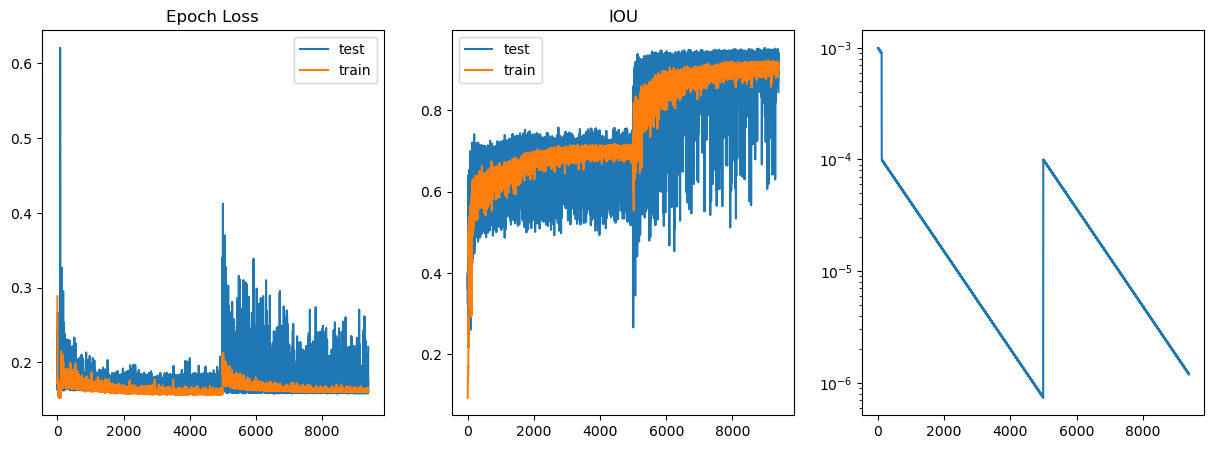

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5 ))

axs[0].plot(np.array(checkpoint['epoch_losses']['test'])/2, label='test')
axs[0].plot(np.array(checkpoint['epoch_losses']['train']),  label='train')
axs[0].set_title("Epoch Loss")
axs[0].legend()

axs[1].plot(np.array(checkpoint['iou_lists']['test'])[:, 1], label='test')
axs[1].plot(np.array(checkpoint['iou_lists']['train'])[:, 1], label='train')
axs[1].set_title("IOU")
axs[1].legend()

axs[2].plot(checkpoint['lr_list'])
axs[2].set_yscale('log')

In [8]:
# mydir = r"D:\RECTDNN\processing\2024-11-15_09-31-24\referencing\\"
mydir = r"D:\RECTDNN\processing\2024-11-15_09-31-24\CornerTest\\"
files = glob.glob(f"{mydir}*.tif")

out_dir = f"{mydir}out\\"

os.makedirs(out_dir, exist_ok=True)

for file_dir in tqdm(files):
    ou_dir = os.path.join(out_dir, os.path.basename(file_dir))
    if os.path.exists(ou_dir):
        continue

    image = Image.open(file_dir).convert('L')
    image = np.asarray(image)
    original_shape = image.shape
    
    test, model = run_nontiled_CNN(file_dir, model)

    test = test * 255
    test = test.astype(np.uint8)

    test = cv2.resize(test[1, :, :], (original_shape[1], original_shape[0]), interpolation= cv2.INTER_LINEAR)

    cv2.imwrite(ou_dir, test)

  0%|          | 0/377 [00:00<?, ?it/s]

In [9]:
try:
    reader
except:
    reader = easyocr.Reader(['en']) 

In [10]:
def check_sectors(sectors):
    """
    Check which image sectors are present and identify any missing sectors.

    Parameters:
        sectors (list): A list of sectors, e.g., ['top left', 'top right', 'bottom left', 'bottom right'].

    Returns:
        dict: A dictionary with 'all_present' as a boolean indicating if all sectors are present,
              and 'missing' as a list of any missing sectors.
    """
    required_sectors = {'top left', 'top right', 'bottom left', 'bottom right'}
    present_sectors = set(sectors)
    missing_sectors = required_sectors - present_sectors
    return len(missing_sectors) <= 1

RLNN        = None
out_sectors = {}
lon_range = (94, 96)
lat_range = (28, 31)

for tile in tqdm(tiles):
    key = os.path.basename(tile).split(".")[0] + ".pickle"
    coordinates = out[0][key] * 2

    im      = cv2.imread(tile)
    im_arry = np.asarray(im)

    # FILTER COORDINATES
    bounds, RLNN = findBounds(tile, RLNN, device='cuda')
    if len(bounds[0].boxes) == 0:
        print(f"{key} could not find bounds, skipping")
        continue
    bbox        = bounds[0].boxes[0].xyxy.numpy().flatten() + np.array([-100, -100, 100, 100])
    coordinates = np.array([a for a in coordinates if bbox[0] <= a[0] <= bbox[2] and bbox[1] <= a[1] <= bbox[3]])

    im_sectors = get_image_sectors(im_arry.shape[0], im_arry.shape[1], coordinates)
    
    if check_sectors(im_sectors):
        out_sectors[key] = {}
        out_sectors[key]['fn']      = tile
        # out_sectors[key]['bounds']  = bounds
        out_sectors[key]['bboxes_cornertext'] = compute_bounding_boxes(coordinates, im_sectors, 800, 400, buffer=200)
        # out_sectors[key]['images']  = compute_bounding_boxes(coordinates, im_sectors, 800, 400, buffer=200)
        try:
            images = extract_bounding_boxes(im_arry, out_sectors[key]['bboxes_cornertext'])
        except Exception as err:
            print(err, traceback.format_exc())
            continue

        out_sectors[key]["coords"] = {}
        for k, v in images.items():

            coord_dict = {"lon" : None, "lat" : None}
            # for x in reader.readtext(v, detail=0, text_threshold=0.9):
            # print(clean_and_convert_coordinates([x]))

            detected_texts  = reader.readtext(v, detail=0, text_threshold=0.9)
            detected_coords = clean_and_convert_coordinates(detected_texts)

            # print(detected_texts)

            for x in detected_coords: 
                if lon_range[0] < x < lon_range[1]:
                    coord_dict["lon"] = x
                if lat_range[0] < x < lat_range[1]:
                    coord_dict["lat"] = x

            out_sectors[key]["coords"][k] = coord_dict
with open(os.path.join(mydir, "CornersReferencing.pickle"), 'wb') as handle:
    pickle.dump(out_sectors, handle, protocol=pickle.HIGHEST_PROTOCOL)

  0%|          | 0/383 [00:00<?, ?it/s]

48201C0100G.pickle could not find bounds, skipping
48201C0415M.pickle could not find bounds, skipping
48201CSTD01.pickle could not find bounds, skipping
48201C0195M.pickle could not find bounds, skipping
48201C0275H.pickle could not find bounds, skipping
48201C0145G.pickle could not find bounds, skipping
48201C0340G.pickle could not find bounds, skipping
48201C0315H.pickle could not find bounds, skipping
48201C0150G.pickle could not find bounds, skipping
48201C0970M.pickle could not find bounds, skipping
48201C0195G.pickle could not find bounds, skipping
48201C0110G.pickle could not find bounds, skipping
48201C0365G.pickle could not find bounds, skipping
48201C0045H.pickle could not find bounds, skipping
48201C0135G.pickle could not find bounds, skipping
48201C0385G.pickle could not find bounds, skipping
48201CSTD1.pickle could not find bounds, skipping
48201C0080G.pickle could not find bounds, skipping
48201CSTD2.pickle could not find bounds, skipping
48201C0235G.pickle could not find

In [11]:
# lon_range = (94, 96)
# lat_range = (28, 31)

# for key in out_sectors.keys():
#     print(key)
#     out_sectors[key]["coords"] = {}
#     for k, v in out_sectors[key]['images'].items():

#         coord_dict = {"lon" : None, "lat" : None}
#         # for x in reader.readtext(v, detail=0, text_threshold=0.9):
#         # print(clean_and_convert_coordinates([x]))

#         detected_texts  = reader.readtext(v, detail=0, text_threshold=0.9)
#         detected_coords = clean_and_convert_coordinates(detected_texts)

#         # print(detected_texts)

#         for x in detected_coords: 
#             if lon_range[0] < x < lon_range[1]:
#                 coord_dict["lon"] = x
#             if lat_range[0] < x < lat_range[1]:
#                 coord_dict["lat"] = x

#         out_sectors[key]["coords"][k] = coord_dict

#         if False:
#             if coord_dict["lon"] is None or coord_dict["lat"] is None:
#                 print(detected_texts)
#                 plt.imshow(v)

#     print(out_sectors[key]["coords"])

In [14]:
import cv2
from rasterio.enums import Resampling
import numpy as np
import math

def rotate_image(image,  angle):
    h, w = image.shape[:2]
    center = (w // 2, h // 2)  # Define the center of the image


    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    
    rotated_image = cv2.warpAffine(image, rotation_matrix, (w, h), flags=cv2.INTER_AREA)
    return rotated_image

def rotate_image_series(filename, rotation_range=(-10, 10)):
    """
    Rotates the image about its center within a specified range and step size.
    
    Args:
        filename (str): Path to the image file.
        rotation_range (tuple): Tuple (min_angle, max_angle) specifying the rotation range in degrees.

    Returns:
        list: A list of numpy arrays, each representing the rotated image.
    """
    # Read the image
    image = cv2.imread(filename)
    image = cv2.resize(image, (512, 512), interpolation=cv2.INTER_AREA)
    if image is None:
        raise FileNotFoundError(f"Image file '{filename}' not found.")
    
    h, w = image.shape[:2]
    center = (w // 2, h // 2)  # Define the center of the image
    
    rotated_images = []
    for angle in rotation_range:
        # Get the rotation matrix
        rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
        # Rotate the image
        rotated_image = cv2.warpAffine(image, rotation_matrix, (w, h), flags=cv2.INTER_AREA)
        rotated_images.append(rotated_image)
    
    return rotated_images

def findBounds_rotatedImages(rotated_images, model, target_size=512, verbose=False, batch=5):
    """
    Placeholder function to find bounds on a series of rotated images.
    
    Args:
        rotated_images (list): A list of numpy arrays representing the rotated images.
        RLNN (Ultralytics YOLO)
        target_size (int)
        verbose (bol)
        
    Returns:
        list: A list of bounding box coordinates for each image.
    """
    # Placeholder shell; replace with your existing implementation
    results = []
    results_struct = []

    for idx in range(0, len(rotated_images), 5):
        # print(len(rotated_images[idx:idx+5]))
        curr_results = model.predict(rotated_images[idx:idx+5], imgsz=target_size, verbose=verbose)
        curr_results = [result.cpu() for result in curr_results]
        curr_results_bbox = [bounds[0].boxes.xyxyn.numpy()[0].flatten() for bounds in curr_results]
        results_struct.extend(curr_results)
        results.extend(curr_results_bbox)
    return results, results_struct

def find_smallest_bounding_box_index(bounding_boxes):
    """
    Finds the index of the smallest bounding box based on area.
    
    Args:
        bounding_boxes (list): A list of bounding boxes, each represented as [x_min, y_min, x_max, y_max].
        
    Returns:
        int: The index of the bounding box with the smallest area.
    """
    areas = [
        (box[2] - box[0]) * (box[3] - box[1])  # Compute area as (x_max - x_min) * (y_max - y_min)
        for box in bounding_boxes
    ]
    return np.argmin(areas), areas # Return the index of the smallest area
"""
RLNN = None

for k, v in tqdm(out_sectors.items()):
    _, RLNN = findBounds(v['fn'], RLNN, )
    RLNN = RLNN.to("cuda")

    angles = np.arange(-5, 5.1, 0.1)

    rotated_images = rotate_image_series(v['fn'], rotation_range=angles)
    bounding_boxes, results_struct = findBounds_rotatedImages(rotated_images, RLNN)
    
    bbox_index, areas = find_smallest_bounding_box_index(bounding_boxes)
    
    print(angles[bbox_index])

    out_sectors[k]['checked_angles']        = angles
    out_sectors[k]['checked_angle_areas']   = areas
    out_sectors[k]['rotated_images']        = rotated_images
    out_sectors[k]['bboxes']                = bounding_boxes
    out_sectors[k]['results_struct']        = results_struct
    out_sectors[k]['best_bbox']             = bounding_boxes[bbox_index]
    out_sectors[k]['best_angle']            = angles[bbox_index]
    out_sectors[k]['best_image']            = rotated_images[bbox_index]
    out_sectors[k]['best_idx']              = bbox_index"""

def calculate_rectangle_rotation(corners):
    """
    Estimate the rotation angle of a rectangle about its center.

    Parameters:
    corners (dict): A dictionary containing the coordinates of the rectangle corners.

    Returns:
    float: The rotation angle in degrees.
    """
    # Extract points from the dictionary
    print(corners.keys())
    top_left = corners['top left']
    top_right = corners['top right']
    
    # Calculate the angle of the top edge with respect to the horizontal
    delta_x = top_right[0] - top_left[0]
    delta_y = top_right[1] - top_left[1]
    
    # Compute the angle in radians and convert to degrees
    angle_radians = math.atan2(delta_y, delta_x)
    angle_degrees = math.degrees(angle_radians)
    
    return angle_degrees

%matplotlib widget

transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)

out_dir = r"D:\RECTDNN\processing\2024-11-15_09-31-24\CornerTest\referenced\\"

for k, v in out_sectors.items():

    image = np.asarray(cv2.imread(out_sectors[k]['fn']))

    out = {}
    for kk, vv in v['bboxes_cornertext'].items():
        out[kk] = calcCenter(vv)

    out_sectors[k]['coordinates_cornertext'] = out
    # out_sectors[k]['estimated_angle'] = calculate_rectangle_rotation(out_sectors[k]['coordinates_cornertext'])

    pic_x, pic_y = [], []
    crs_x, crs_y = [], []

    print(k)
    for kk, vv in v['coordinates_cornertext'].items():
        try:
            reproj = transformer.transform(v['coords'][kk]['lon'], v['coords'][kk]['lat'])
        except:
            continue
        pic_x.append(vv[0])
        pic_y.append(image.shape[0] - vv[1])

        crs_x.append(-1 * reproj[0])
        crs_y.append(reproj[1])

        print(f"{v['coords'][kk]['lon']:.4f}\t{v['coords'][kk]['lat']:.4f}\t{pic_x[-1]:.2f}\t{pic_y[-1]:.2f}")

    affine = affineTransformation(pic_x, pic_y, crs_x, crs_y)
    transform = bboxTransformToCRS(affine.matrix, image)

    # OUTPUT NAME DIRECTORY FOR TILES
    ras_name = os.path.join(out_dir, os.path.basename(out_sectors[k]['fn']))

    # plt.figure()
    # plt.imshow(im)
    # plt.scatter([vv[0] for _, vv in v['coordinates_cornertext'].items()], [vv[1] for _, vv in v['coordinates_cornertext'].items()])

    with rio.open(ras_name, 'w',
        driver='GTiff', count=1, dtype=image.dtype,
        height=image.shape[0], width=image.shape[1],
        crs=f'EPSG:3857',
        # compress= 'CCITTFAX4',
        compress='lzw',
        transform=rio.Affine(*transform.flatten()[:6])) as dst:
            dst.write(image[:, :, 0], 1) 
    
    with rio.open(ras_name, 'r+') as dst:
        # Step 3: Define the decimation factors for the overviews
        overviews = [2, 4, 8, 16, 32, 64, 128]  # Downscaling factors
        dst.build_overviews(overviews, Resampling.average)

        # Step 4: Update metadata to specify compression and overview inclusion
        dst.update_tags(ns='TIFF', RESAMPLING='AVERAGE')
        dst.update_tags(ns='OVERVIEWS', RESOLUTION_LEVELS=len(overviews))

48201C0555J.pickle
95.0000	30.0000	527.60	9671.60
94.9375	30.0000	8483.56	9669.09
95.0000	29.9375	465.26	494.54
94.9375	29.9375	8500.55	531.19
48201C0245K.pickle
95.5625	30.0625	1983.12	9677.71
95.5000	30.0625	10006.73	9698.08
95.5625	30.0000	2015.98	522.24
95.5000	30.0000	10058.99	555.36
48201C0320J.pickle
95.1875	30.0625	1987.13	9677.13
95.1875	30.0000	1993.12	518.15
48201C0495J.pickle
95.3125	29.9375	2029.65	9668.93
95.2500	29.9375	10088.32	9653.71
95.3125	29.8750	2107.17	492.41
95.2500	29.8750	10086.27	511.29
48201C0660J.pickle
95.4375	29.8750	1958.91	9671.11
95.3750	29.8750	10023.46	9704.45
95.4375	29.8125	2101.72	499.53
95.3750	29.8125	10063.92	554.53
48201C1045J.pickle
95.2500	29.5625	8451.56	9701.90
95.3125	29.5000	398.05	540.64
95.2500	29.5000	8495.64	561.87
48201C0465J.pickle
95.5000	29.9375	1979.39	9694.21
95.4375	29.9375	10010.04	9718.31
95.5000	29.8750	2017.94	538.02
95.4375	29.8750	10057.23	574.30
48201C0420J.pickle
95.6875	29.9375	2001.20	9738.86
95.6250	29.9375	10060.58

In [17]:
from rasterio.io import MemoryFile

out_dir = r"D:\RECTDNN\processing\2024-11-15_09-31-24\CornerTest\referenced\\"

# Directories
dir_a = r"D:\RECTDNN\processing\2024-11-15_09-31-24\CornerTest\referenced\\"
dir_b = r"D:\RECTDNN\processing\2024-11-15_09-31-24\CornerTest\out\\" 
output_dir = r"D:\RECTDNN\processing\2024-11-15_09-31-24\CornerTest\out_referenced\\"  # Directory to save the georeferenced rasters from B

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Process rasters
for filename in os.listdir(dir_a):
    path_a = os.path.join(dir_a, filename)
    path_b = os.path.join(dir_b, filename)
    
    # Check if matching file exists in B
    if os.path.exists(path_b):
        # Open the georeferenced raster from A
        with rio.open(path_a) as src_a:
            # Extract metadata and transform
            metadata = src_a.meta.copy()
        
        # Open the non-georeferenced raster from B
        with rio.open(path_b) as src_b:
            # Read data from the non-georeferenced raster
            data = src_b.read()
        
        # Update metadata of raster B with georeferencing from A
        metadata.update({
            "transform": src_a.transform,
            "crs": src_a.crs,
            "width": src_a.width,
            "height": src_a.height,
        })
        
        # Write to a new file in the output directory
        output_path = os.path.join(output_dir, filename)
        with rio.open(output_path, "w", **metadata) as dst:
            dst.write(data)

        with rio.open(output_path, 'r+') as dst:
            overviews = [2, 4, 8, 16, 32, 64, 128] 
            dst.build_overviews(overviews, Resampling.average)
            dst.update_tags(ns='TIFF', RESAMPLING='AVERAGE')
            dst.update_tags(ns='OVERVIEWS', RESOLUTION_LEVELS=len(overviews))
        
        print(f"Georeferencing applied to {filename}")
    else:
        print(f"Matching file for {filename} not found in {dir_b}. Skipping.")

Georeferencing applied to 48201C0015J.tif
Georeferencing applied to 48201C0020J.tif
Georeferencing applied to 48201C0045J.tif
Georeferencing applied to 48201C0065J.tif
Georeferencing applied to 48201C0070J.tif
Georeferencing applied to 48201C0090J.tif
Georeferencing applied to 48201C0120J.tif
Georeferencing applied to 48201C0140J.tif
Georeferencing applied to 48201C0170J.tif
Georeferencing applied to 48201C0180J.tif
Georeferencing applied to 48201C0185J.tif
Georeferencing applied to 48201C0190J.tif
Georeferencing applied to 48201C0195J.tif
Georeferencing applied to 48201C0205J.tif
Georeferencing applied to 48201C0210J.tif
Georeferencing applied to 48201C0215J.tif
Georeferencing applied to 48201C0220J.tif
Georeferencing applied to 48201C0230J.tif
Georeferencing applied to 48201C0235J.tif
Georeferencing applied to 48201C0240J.tif
Georeferencing applied to 48201C0245J.tif
Georeferencing applied to 48201C0245K.tif
Georeferencing applied to 48201C0255J.tif
Georeferencing applied to 48201C02

In [20]:
import os
import cv2

def resize_images_in_directory(root_dir):
    # Loop through all subdirectories and files
    for subdir, _, files in os.walk(root_dir):
        for file in files:
            file_path = os.path.join(subdir, file)
            
            # Check if the file is an image based on its extension
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.tif')):
                try:
                    # Read the image
                    img = cv2.imread(file_path)
                    if img is None:
                        print(f"Skipping non-image file: {file_path}")
                        continue
                    
                    # Get new dimensions (half the original size)
                    height, width = img.shape[:2]
                    new_dimensions = (width // 2, height // 2)
                    
                    # Resize the image
                    resized_img = cv2.resize(img, new_dimensions, interpolation=cv2.INTER_AREA)
                    
                    # Overwrite the original file with the resized image
                    cv2.imwrite(file_path, resized_img)
                    print(f"Resized and saved: {file_path}")
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")

def doubleImagesInDirectory(root_dir):
    # Loop through all subdirectories and files
    for subdir, _, files in os.walk(root_dir):
        for file in files:
            file_path = os.path.join(subdir, file)
            
            # Check if the file is an image based on its extension
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.tif')):
                try:
                    # Read the image
                    img = cv2.imread(file_path)
                    if img is None:
                        print(f"Skipping non-image file: {file_path}")
                        continue
                    
                    # Get new dimensions (half the original size)
                    height, width = img.shape[:2]
                    new_dimensions = (int(width * 2), int(height * 2))
                    
                    # Resize the image
                    resized_img = cv2.resize(img, new_dimensions, interpolation=cv2.INTER_AREA)
                    
                    # Overwrite the original file with the resized image
                    cv2.imwrite(file_path, resized_img)
                    print(f"Resized and saved: {file_path}")
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")

# Replace 'path_to_your_directory' with the directory path you want to process
# path_to_your_directory = r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\FLNN\AAA_NewDataset_3\update\\"
# resize_images_in_directory(path_to_your_directory)

doubleImagesInDirectory(r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\FLNN\AAA_NewDataset_3\000_drawn_double\\")

Resized and saved: C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\FLNN\AAA_NewDataset_3\000_drawn_double\\48201C0845J.jpg
Resized and saved: C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\FLNN\AAA_NewDataset_3\000_drawn_double\\48201C0845K.jpg
Resized and saved: C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\FLNN\AAA_NewDataset_3\000_drawn_double\\48201C0855J.jpg
Resized and saved: C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\FLNN\AAA_NewDataset_3\000_drawn_double\\48201C0855K.jpg
Resized and saved: C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\FLNN\AAA_NewDataset_3\000_drawn_double\\48201C0865J.jpg
Resized and saved: C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\FLNN\AAA_NewDataset_3\000_drawn_double\\48201C0865K.jpg
Resized and saved: C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\FLNN\AAA_NewDataset_3\000_drawn_double\\48201C0865L.jpg

In [15]:
len(out_sectors)

156

In [ ]:
im = rotate_image(np.asarray(cv2.imread(out_sectors[k]['fn'])), out_sectors[k]['estimated_angle'])

RLNN = None
_, RLNN = findBounds(v['fn'], RLNN, device='cuda')
# RLNN = RLNN.to("cuda")

plt.imshow(im)
plt.scatter([vv[0] for _, vv in v['coordinates_cornertext'].items()], [vv[1] for _, vv in v['coordinates_cornertext'].items()])

In [ ]:
plt.imshow(_[0].plot())
plt.scatter()

TypeError: scatter() missing 2 required positional arguments: 'x' and 'y'

In [ ]:


    # out_sectors[k]['coordinates_cornertext'] = [calcCenter(vv) for _, vv in v['bboxes_cornertext'].items()]
    # print(out_sectors[k]['coordinates_cornertext'])

    # out_sectors[k]['coordinates_cornertext'] = calcCenter(v['bboxes_cornertext'])
    # print(out_sectors[k]['coordinates_cornertext'])

# [calcCenter(v) for _, v in out_sectors['48201C0835J.pickle']['bboxes_cornertext'].items()]

NameError: name 'results_struct' is not defined

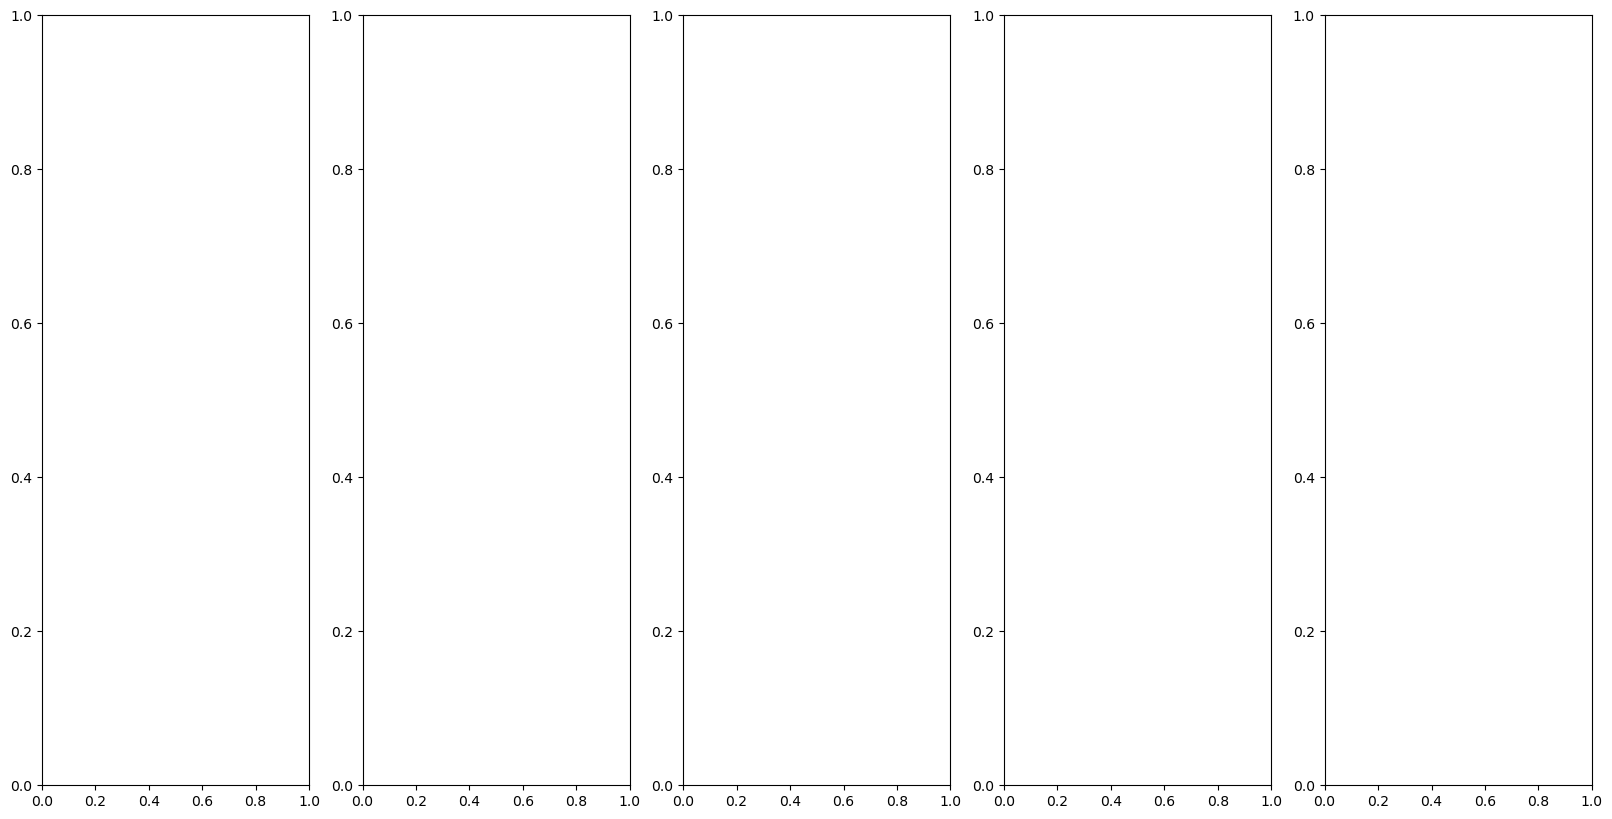

In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(20, 10))

for i in range(0, 100, 20):
    axs[i // 20].imshow(results_struct[i].plot())
    axs[i // 20].set_title(f"Area: {out_sectors['48201C0835J.pickle']['checked_angle_areas'][i]} px\nAngle: {out_sectors['48201C0835J.pickle']['checked_angles'][i]:.1f}")

  0%|          | 0/8 [00:00<?, ?it/s]

[    0.18245    0.061506     0.86622      0.9391]
[[     2216.4      589.68]
 [      10284      675.12]
 [      10158      9649.6]
 [     2089.9      9564.2]]
[     2152.9       10221       10221      2152.9] [      11171       11171      2195.8      2195.8]


NameError: name 'error' is not defined

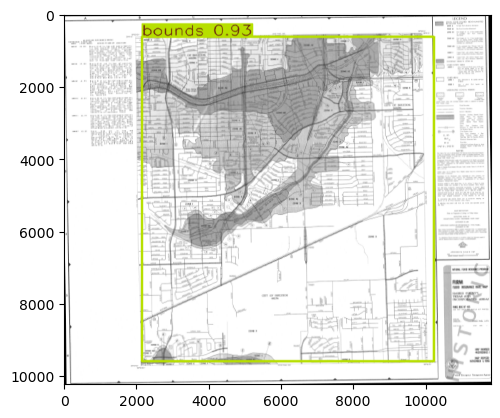

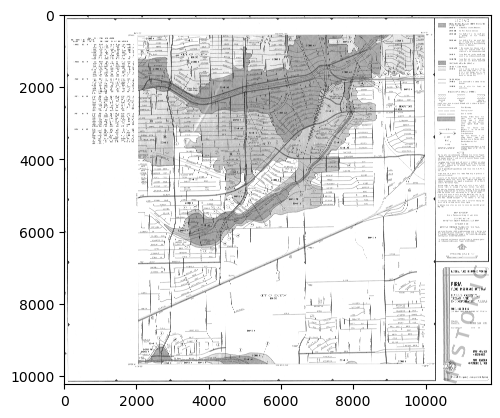

In [ ]:
def rotate_bounding_box_back(bbox, angle, image_shape):
    """
    Computes the original image coordinates for a bounding box after a rotation.

    Args:
        bbox (list): Bounding box in the rotated image, formatted as [x_min, y_min, x_max, y_max].
        angle (float): The rotation angle (in degrees) used to rotate the image.
        image_shape (tuple): Shape of the original image as (height, width).

    Returns:
        np.ndarray: The original image coordinates of the bounding box, as a 4x2 array.
    """
    # h, w = image_shape[:2]
    center = (0.5, 0.5)  # Center of the image
    
    # Define the corners of the bounding box
    corners = np.array([
        [bbox[0], bbox[1]],  # Top-left corner
        [bbox[2], bbox[1]],  # Top-right corner
        [bbox[2], bbox[3]],  # Bottom-right corner
        [bbox[0], bbox[3]],  # Bottom-left corner
    ])
    
    # Compute the inverse rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    inverse_rotation_matrix = cv2.invertAffineTransform(rotation_matrix)
    
    # Add a third column of ones to the corners for affine transformation
    corners_augmented = np.hstack([corners, np.ones((4, 1))])
    
    # Transform the corners back to the original image space
    original_coords = np.dot(corners_augmented, inverse_rotation_matrix.T)

    original_coords[:, 0] = original_coords[:, 0] * image_shape[1]
    original_coords[:, 1] = original_coords[:, 1] * image_shape[0]

    corners[:, 0] = corners[:, 0] * image_shape[1]
    corners[:, 1] = corners[:, 1] * image_shape[0]
    """
    if new_shape is not None:
        print(new_shape)
        print(original_coords)
        print(original_coords[:, 0])
        original_coords[:, 0] = original_coords[:, 0] / h * new_shape[0]
        original_coords[:, 1] = original_coords[:, 1] / w * new_shape[1]"""
    
    return original_coords, corners

for k, v in tqdm(out_sectors.items()):
    print(v['best_bbox'])
    image = cv2.imread(v['fn'])
    image_red = cv2.resize(v['results_struct'][v['best_idx']].plot(), (image.shape[1], image.shape[0]), interpolation=cv2.INTER_AREA)
    original_coords, corners = rotate_bounding_box_back(v['best_bbox'], v['best_angle'], image.shape)
    print(original_coords)
    plt.imshow(image_red)
    plt.figure()
    plt.imshow(image)
    # plt.scatter(original_coords[:, 0], original_coords[:, 1])
    print(corners[:, 0], image.shape[1] - corners[:, 1])
    # plt.scatter( )
    error

array([[[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [88, 88, 88],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [88, 88, 88],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[88, 88, 88],
        [88, 88, 88],
        [88, 88, 88],
        ...,
        [88, 88, 88],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       ...,

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [96, 96, 96],
        ...,
        [96, 96, 96],
        [88, 88, 88],
        [88, 88, 88]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [88, 88, 88],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [88, 88, 88],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]]], dtype=uint8)

In [ ]:
# print(corners[:, 1], corners[:, 0] / , image.shape)

test = v['best_bbox'].copy()
print(test * 512)
print(image.shape)

test2 = test * np.array([image.shape[0], image.shape[1], image.shape[0], image.shape[1]])
print(test2)

test2[1] = image.shape[1] - test2[1]
test2[3] = image.shape[1] - test2[3]
print(test2)

[      81.91      80.814      442.43      488.37]
(10225, 11910, 3)
[     1635.8      1879.9      8835.7       11360]
[     1635.8       10030      8835.7      549.64]


In [ ]:
image.shape[0], image.shape[1]

(10225, 11910)

In [ ]:
len(v['results_struct'][v['']])

KeyError: ''

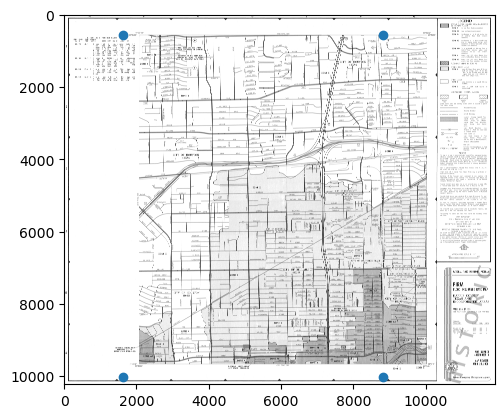

In [ ]:
plt.imshow(image)
pic_x, pic_y   = bbox_to_coords_raster(test2)
plt.scatter(pic_x, pic_y)